# Let us try to do now polynomial regression. 
We got a decent fit with linear regression. However, since both training and testing MSE are low, we might be underfitting.
Let us move to polynomial regression and uncover deeper what is happening.

This code fits a multi-output plynomial regression model to predict the meshed dendritic field, effectively training one polynomial regression model per pixel. The model achieves low MSE on both training and testing sets, visual reconstruction of the predicted images a good performance overall.


Polynomial degree is a hyperparameter than was tuned by trial and error.

In [1]:
# Cell 0

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [ ]:
# Cell 1

# 1. Load the data
X_train = np.load("X_train.npy")
y_train = np.load("Y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("Y_test.npy")

# 2. Flatten outputs
y_train_flat = y_train.reshape(y_train.shape[0], -1)
y_test_flat = y_test.reshape(y_test.shape[0], -1)

In [ ]:
# Cell 2

# Cleaned Data (without index 228)

# Remove index 228
X_train_clean = np.delete(X_train, 228, axis=0)
y_train_flat_clean = np.delete(y_train_flat, 228, axis=0)


Let us define a function for polynomial regression

In [6]:
# Cell 3

def polynomial_regression_clean(degree_k, X_train_clean, y_train_flat_clean, X_test, y_test_flat):
    """
    Perform polynomial regression of degree k on cleaned dataset (outlier 228 removed).
    Plots residuals and mean residuals. Prints MSE.
    """
    
    # 1. Create polynomial features
    poly = PolynomialFeatures(degree=degree_k)
    X_train_poly = poly.fit_transform(X_train_clean)
    X_test_poly = poly.transform(X_test)
    
    # 2. Fit the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_flat_clean)
    
    # 3. Predict
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    y_train_pred = np.clip(y_train_pred,0,1)
    y_test_pred = np.clip(y_test_pred, 0 , 1)
    
    # 4. Residuals
    residuals_train = (y_train_flat_clean - y_train_pred).flatten()
    residuals_test = (y_test_flat - y_test_pred).flatten()
    
    
    # 6. Mean Residuals per Sample
    mean_residual_per_sample = residuals_train.reshape(y_train_flat_clean.shape[0], -1).mean(axis=1)
    
    plt.figure(figsize=(8,6))
    plt.scatter(np.arange(mean_residual_per_sample.shape[0]), mean_residual_per_sample, alpha=0.5, s=5, label=f"E[Residual | X] (Degree {degree_k})")
    plt.axhline(y=0, color='black', linestyle='--', label='Zero Line')
    plt.axhline(y=mean_residual_per_sample.mean(), color='red', linestyle='-', label='Global Mean Residual')
    plt.xlabel('Sample Index')
    plt.ylabel('Mean Residual per Sample')
    plt.title(f'Estimated E[Residual | X] across Samples (Degree {degree_k})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 7. Print MSEs
    print(f"Train MSE (Degree {degree_k}): {mean_squared_error(y_train_flat_clean, y_train_pred):.5f}")
    print(f"Test MSE (Degree {degree_k}): {mean_squared_error(y_test_flat, y_test_pred):.5f}")
    
    # 8. Analyze Coefficients by Degree
    coef_matrix = model.coef_  # shape (n_outputs, n_features)
    mean_abs_coef = np.mean(np.abs(coef_matrix), axis=0)  # (n_features,)
    
    # Map feature names to their degrees
    feature_names = poly.get_feature_names_out()
    
    degrees = []
    for name in feature_names:
        if name == '1':
            degrees.append(0)
        else:
            degree = sum([int(term.split('^')[1]) if '^' in term else 1 for term in name.split(' ')])
            degrees.append(degree)
    degrees = np.array(degrees)
    
    # For each degree, calculate average coefficient
    for d in range(degree_k + 1):
        avg_coef = np.mean(mean_abs_coef[degrees == d])
        print(f"Average |Coefficient| for Degree {d} Terms: {avg_coef:.5e}")
    
    
    return model


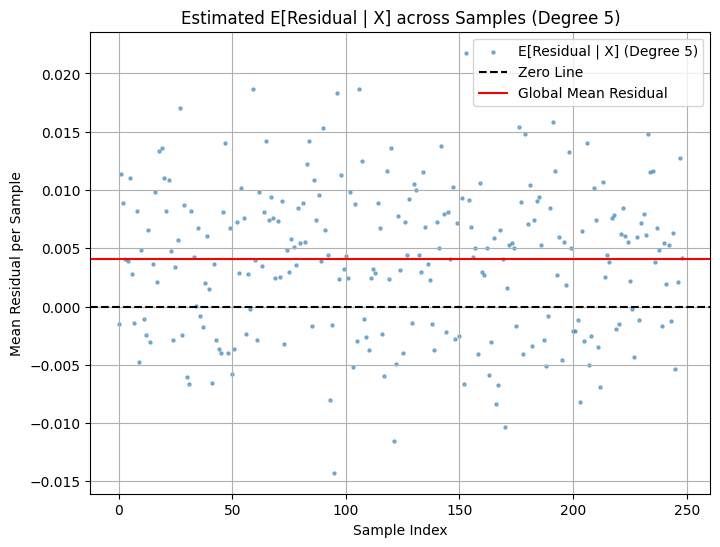

Train MSE (Degree 5): 0.00192
Test MSE (Degree 5): 0.01287
Average |Coefficient| for Degree 0 Terms: 1.97756e-01
Average |Coefficient| for Degree 1 Terms: 5.03475e-01
Average |Coefficient| for Degree 2 Terms: 1.53195e+01
Average |Coefficient| for Degree 3 Terms: 3.10196e+01
Average |Coefficient| for Degree 4 Terms: 3.71745e+01
Average |Coefficient| for Degree 5 Terms: 2.42572e+01


In [7]:
k=5
model_degk = polynomial_regression_clean(degree_k=k, 
                                          X_train_clean=X_train_clean, 
                                          y_train_flat_clean=y_train_flat_clean, 
                                          X_test=X_test, 
                                          y_test_flat=y_test_flat)

No clear outlier, points near 0.

In [8]:
def plot_pixel_regressions(model, poly, X_test, y_test_flat, num_pixels=5):
    """
    Pick random pixels, scatter plot true vs predicted values (no lines).
    Two plots per pixel: 1) Sample index scatter; 2) True vs Predicted scatter.
    """
    
    n_pixels = y_test_flat.shape[1]  # total number of pixels
    selected_pixels = np.random.choice(n_pixels, num_pixels, replace=False)
    
    print(f"Selected pixel indices: {selected_pixels}")
    
    X_test_poly = poly.transform(X_test)
    y_test_pred_flat = model.predict(X_test_poly)
    
    for pixel_idx in selected_pixels:
        true_values = y_test_flat[:, pixel_idx]
        pred_values = y_test_pred_flat[:, pixel_idx]
        
        # Create a figure with 2 subplots side by side
        fig, axs = plt.subplots(1, 2, figsize=(14,6))
        
        # === First plot: sample index vs true/predicted (SCATTER ONLY)
        axs[0].scatter(range(len(true_values)), true_values, color='blue', alpha=0.5, label='True Data', s=5)
        axs[0].scatter(range(len(pred_values)), pred_values, color='red', alpha=0.5, label='Predicted Data', s=5)
        axs[0].set_xlabel('Sample Index')
        axs[0].set_ylabel('Pixel Value')
        axs[0].set_title(f'Pixel {pixel_idx}: Value vs Sample (Scatter)')
        axs[0].legend()
        axs[0].grid(True)

        # === Second plot: true vs predicted scatter
        axs[1].scatter(true_values, pred_values, color='green', alpha=0.5, label='Predicted vs True', s=10)
        axs[1].plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect Prediction (y=x)')
        axs[1].set_xlabel('Ground Truth')
        axs[1].set_ylabel('Prediction')
        axs[1].set_title(f'Pixel {pixel_idx}: Prediction vs True')
        axs[1].legend()
        axs[1].grid(True)
        axs[1].axis('square')
        axs[1].set_xlim(0, 1)
        axs[1].set_ylim(0, 1)

        plt.tight_layout()
        plt.show()


Selected pixel indices: [3546 1074 8933 9712 4944]


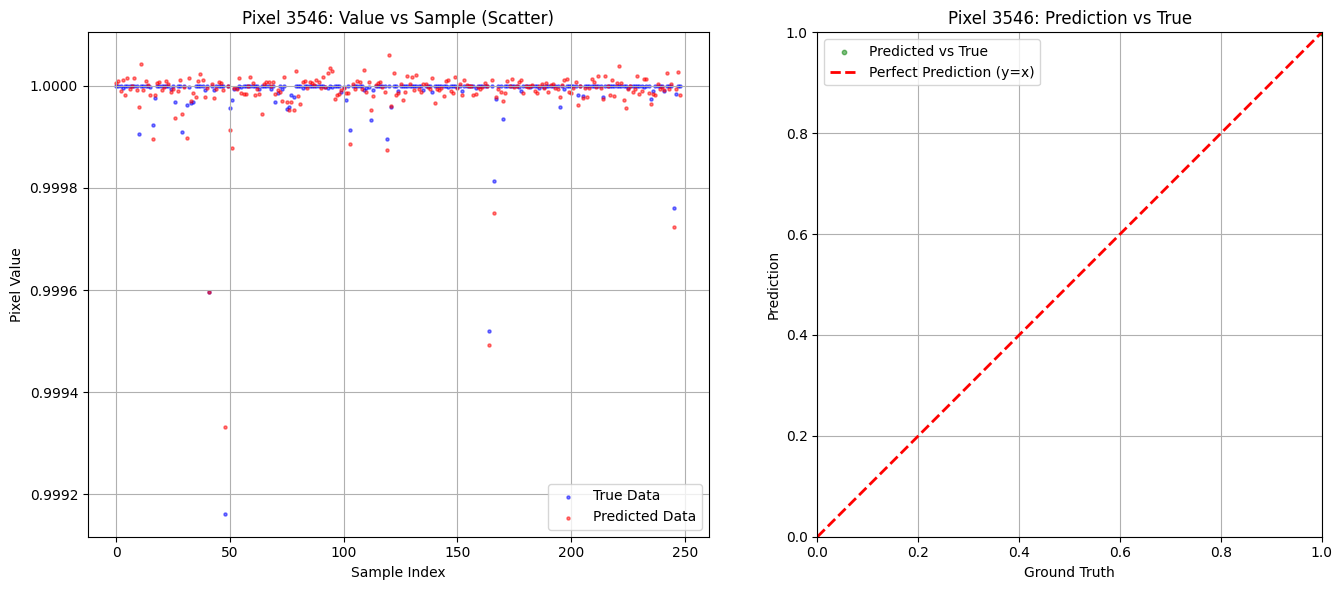

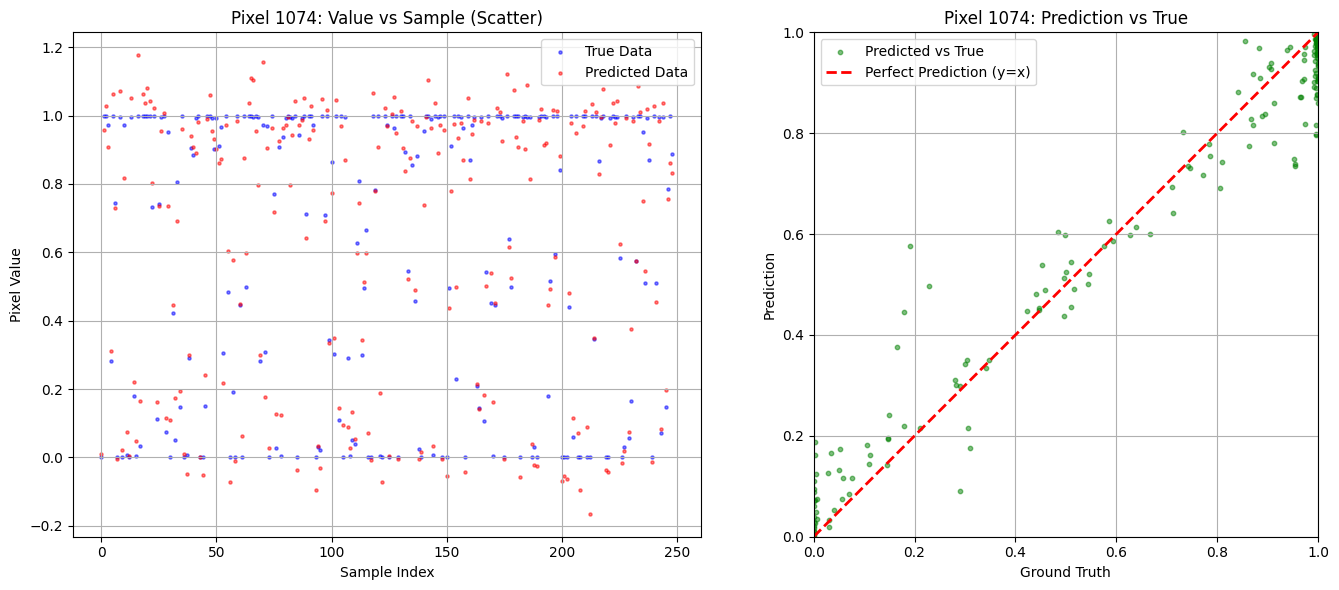

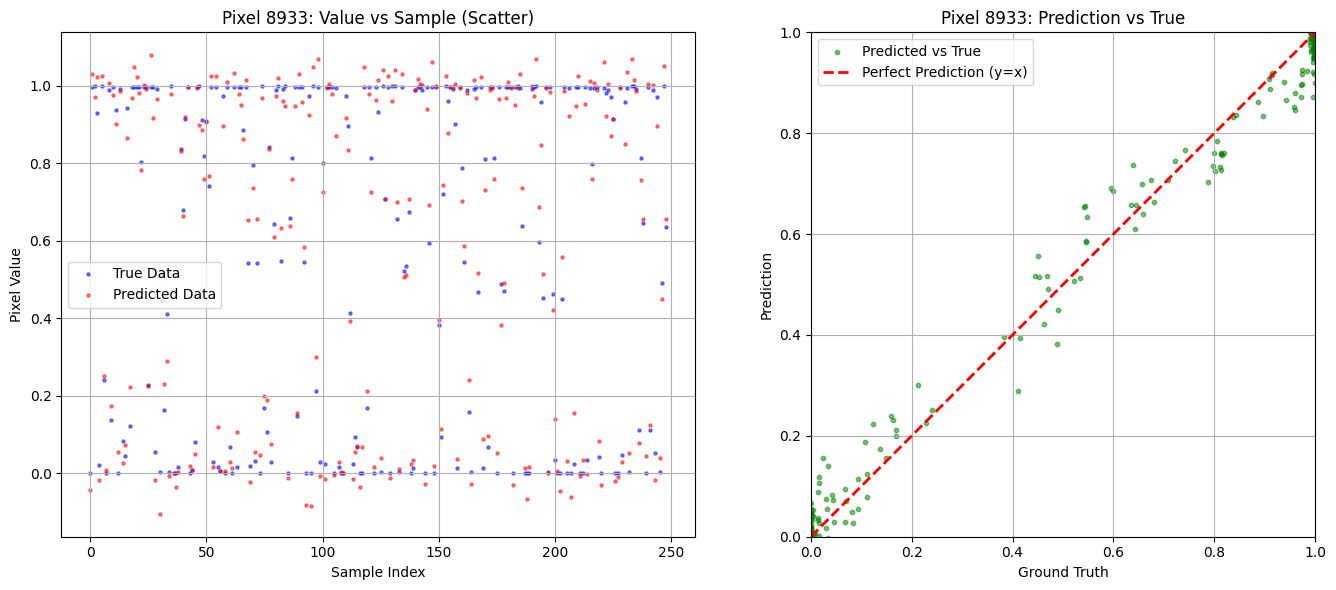

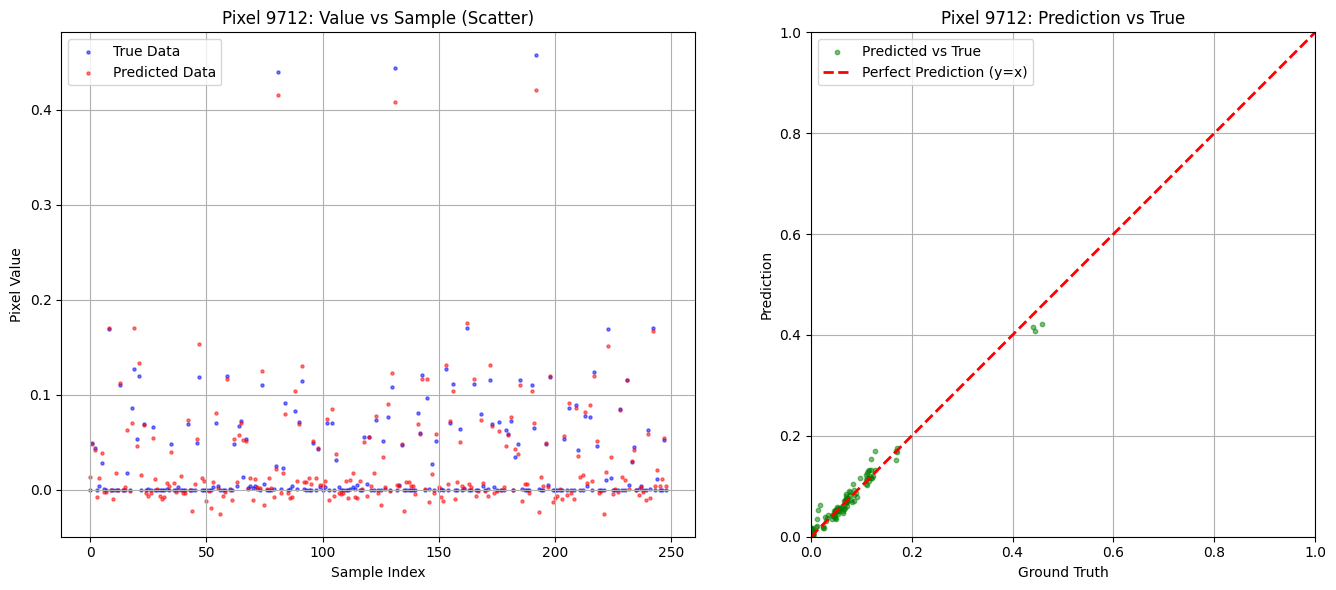

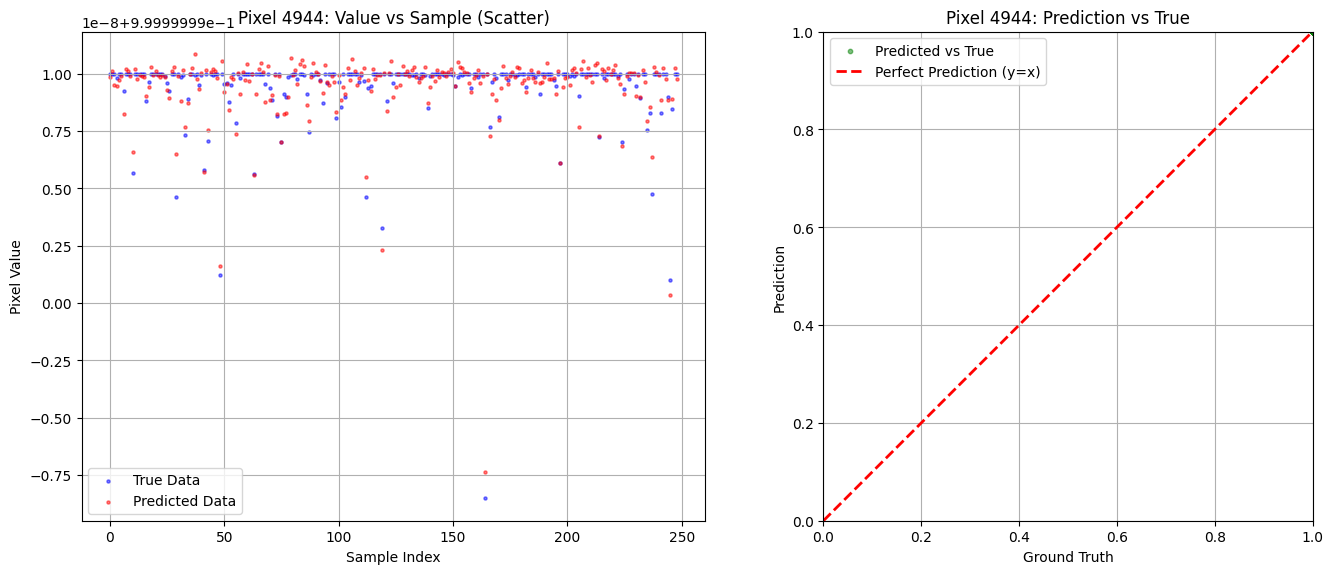

In [ ]:
# Cell 4
plot_pixel_regressions(model_degk, PolynomialFeatures(degree=k).fit(X_train_clean), X_train_clean, y_train_flat_clean)


In [ ]:
# Cell 5

def reconstruct_predictions(model, poly, X_test, y_test_flat, num_samples=5):
    """
    For a few random test samples, reconstruct and plot:
    - Ground truth morphology
    - Predicted morphology
    Side by side, with the SAME color scale.
    """
    X_test_poly = poly.transform(X_test)
    y_test_pred_flat = model.predict(X_test_poly)
    
    n_samples = y_test_flat.shape[0]
    n_pixels = y_test_flat.shape[1]
    
    # Randomly select samples
    selected_samples = np.random.choice(n_samples, size=num_samples, replace=False)
    
    print(f"Selected test sample indices: {selected_samples}")
    
    for idx in selected_samples:
        true_image = y_test_flat[idx].reshape(100, 100)
        pred_image = y_test_pred_flat[idx].reshape(100, 100)
        
        # Find the global min and max across both images
        vmin = min(true_image.min(), pred_image.min())
        vmax = max(true_image.max(), pred_image.max())
        
        # Create a figure with 2 subplots
        fig, axs = plt.subplots(1, 2, figsize=(12,5))
        
        # === Left: Ground Truth ===
        im0 = axs[0].imshow(true_image, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
        axs[0].set_title(f'Ground Truth - Test Sample {idx}')
        axs[0].axis('off')
        fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
        
        # === Right: Prediction ===
        im1 = axs[1].imshow(pred_image, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
        axs[1].set_title(f'Predicted - Test Sample {idx}')
        axs[1].axis('off')
        fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
        
        plt.tight_layout()
        plt.show()


Selected test sample indices: [ 4 43 23  0 15]


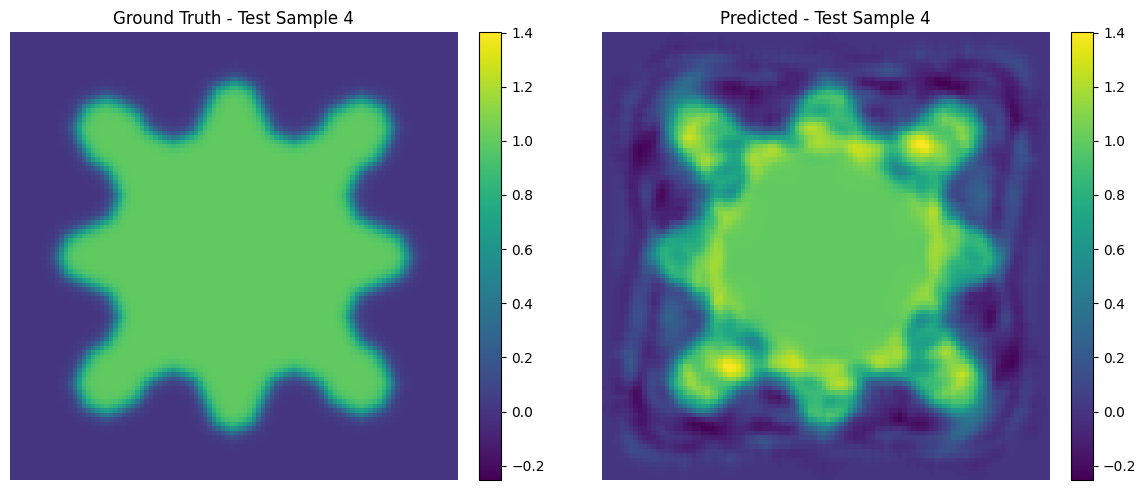

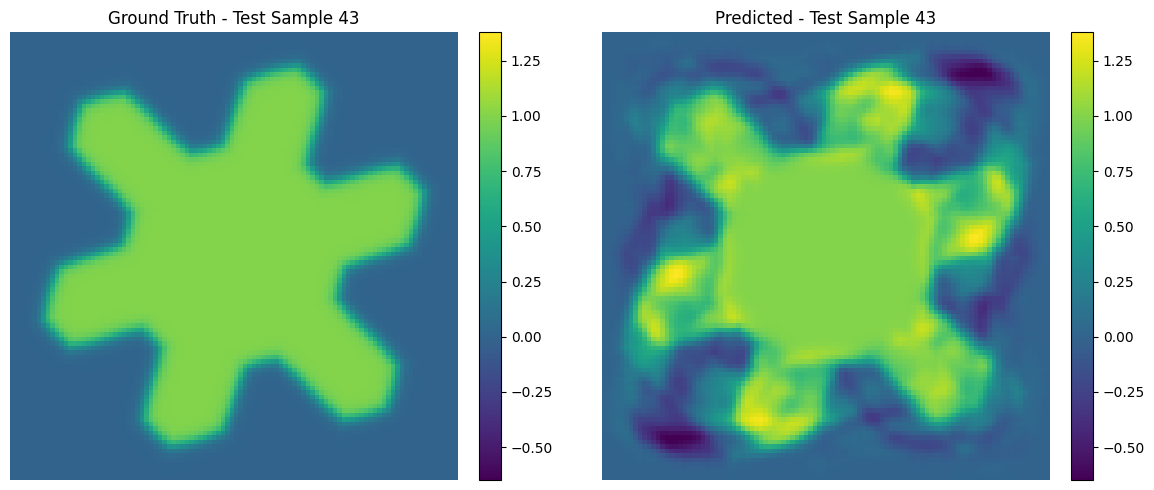

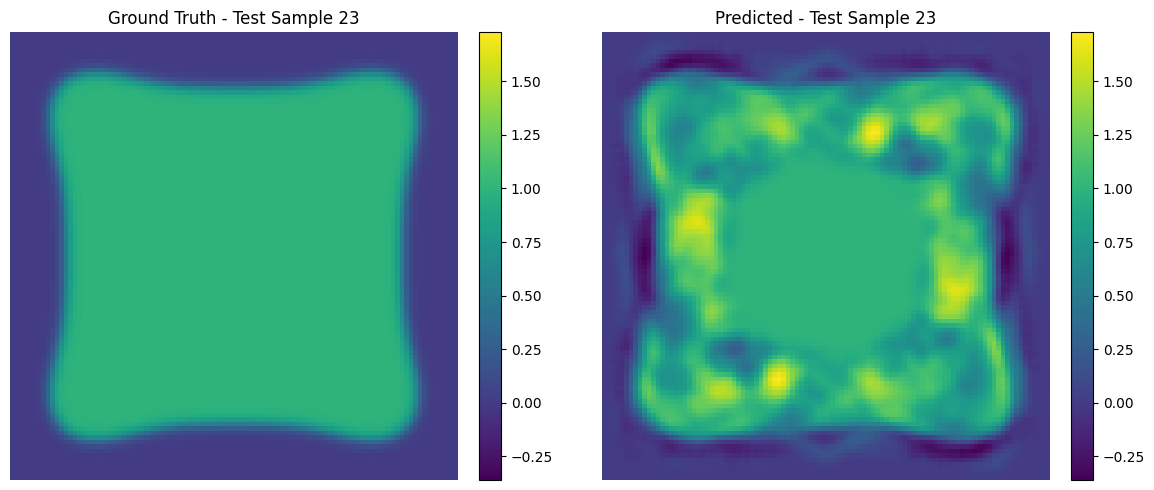

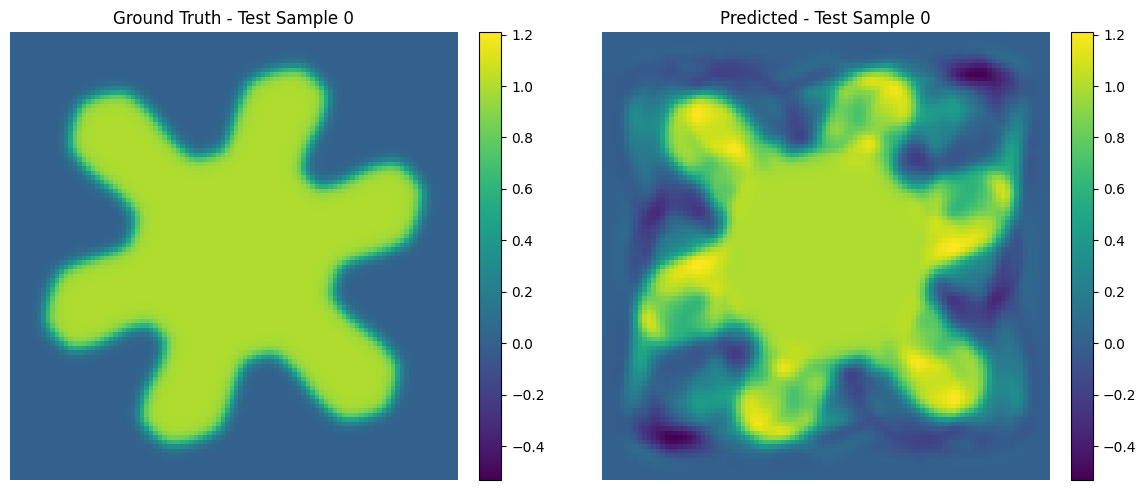

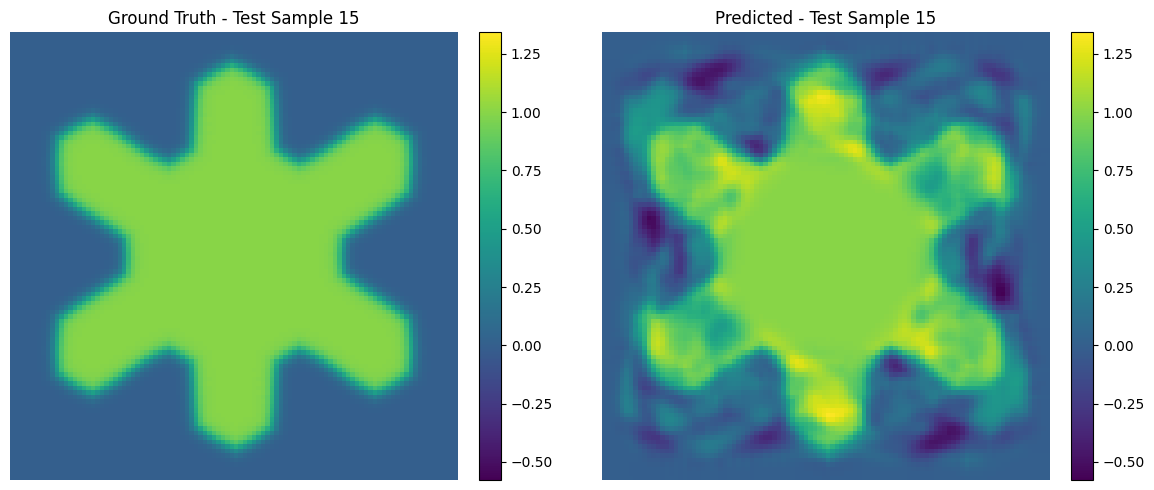

In [ ]:
# Cell 6

reconstruct_predictions(model_degk, PolynomialFeatures(degree=k).fit(X_train_clean), X_test, y_test_flat)

We plot many things.
First - a prediction vs ground truth, if the model is good then the points will be around the line y = x.
Second - a predcition AND ground truth plot, if the model is good then the predictions and real points should be close to each other.
Third - we reconstructed some images.

All of them gave us good results.